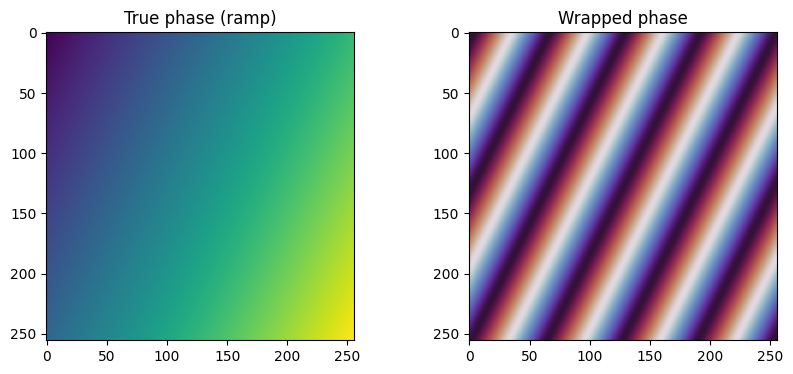

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def make_ramp(Nx, Ny, px=1.0, py=1.0, slope_x=0.05, slope_y=0.0):
    """
    Create a 2D linear ramp phase.
    
    Parameters
    ----------
    Nx, Ny : int
        Grid size in x and y.
    px, py : float
        Pixel sizes (arbitrary units).
    slope_x, slope_y : float
        Phase slope in rad per pixel along x and y.
        
    Returns
    -------
    phi_true : np.ndarray
        True continuous phase (before wrapping).
    phi_wrap : np.ndarray
        Wrapped phase in (-pi, pi].
    """
    # coordinate grids (centered at 0)
    x = (np.arange(Nx) - Nx/2) * px
    y = (np.arange(Ny) - Ny/2) * py
    X, Y = np.meshgrid(x, y, indexing="xy")
    
    # linear phase ramp
    phi_true = slope_x * X + slope_y * Y
    
    # wrapped phase
    phi_wrap = np.angle(np.exp(1j * phi_true))
    
    return phi_true, phi_wrap

phi_true, phi_wrap = make_ramp(Nx=256, Ny=256, slope_x=0.1, slope_y=0.05)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(phi_true, cmap="viridis")
axs[0].set_title("True phase (ramp)")
axs[1].imshow(phi_wrap, cmap="twilight")
axs[1].set_title("Wrapped phase")
plt.show()


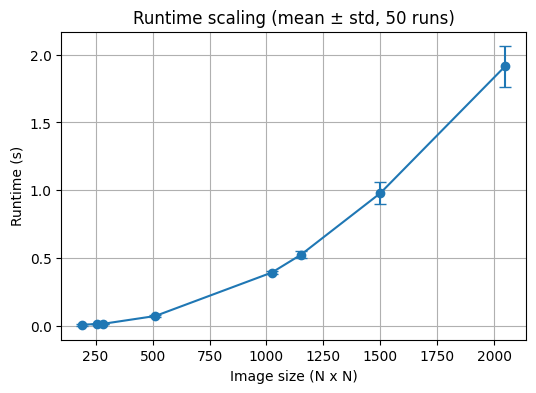

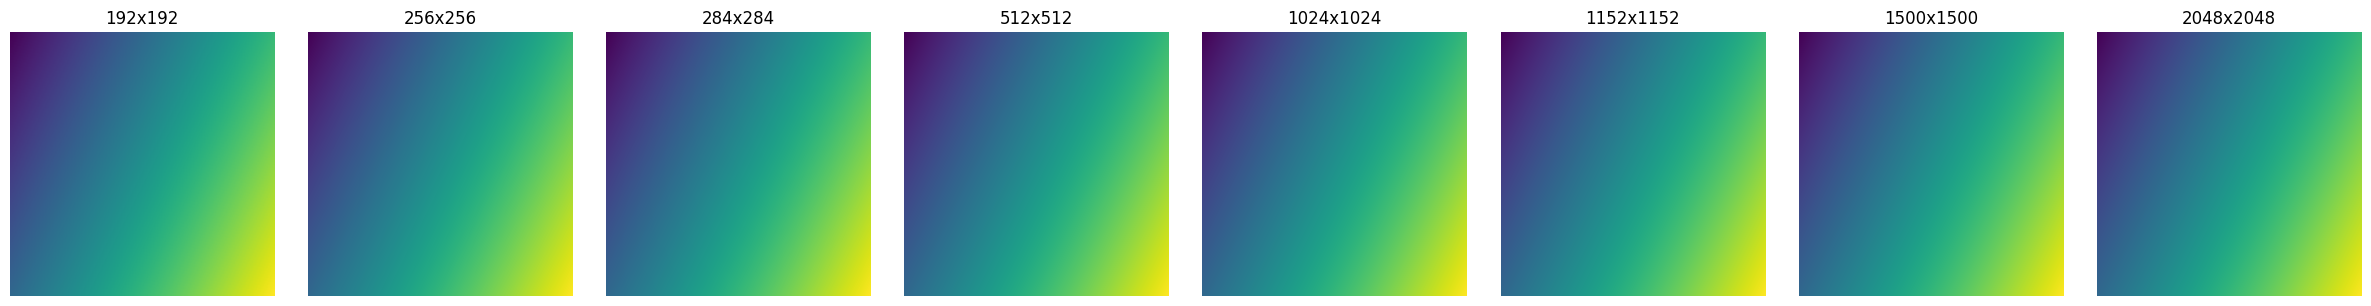

In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase

sizes = [192, 256, 284, 512, 1024, 1152, 1500, 2048]
repeats = 50  # how many times per size

times_mean = []
times_std = []
unwrapped_results = {}

for N in sizes:
    durations = []
    phi_true, phi_wrap = make_ramp(N, N, slope_x=0.1, slope_y=0.05)

    # run several times for timing
    for _ in range(repeats):
        start = time.time()
        phi_unwrapped = unwrap_phase(phi_wrap)
        end = time.time()
        durations.append(end - start)

    # keep the last run just for plotting
    unwrapped_results[N] = phi_unwrapped

    durations = np.array(durations)
    times_mean.append(durations.mean())
    times_std.append(durations.std())

# --- plot runtimes with error bars ---
plt.figure(figsize=(6,4))
plt.errorbar(sizes, times_mean, yerr=times_std, fmt="o-", capsize=4)
plt.xlabel("Image size (N x N)")
plt.ylabel("Runtime (s)")
plt.title(f"Runtime scaling (mean ± std, {repeats} runs)")
plt.grid(True)
plt.show()

# --- plot unwrapped phase side by side ---
fig, axs = plt.subplots(1, len(sizes), figsize=(3*len(sizes), 3))
for i, N in enumerate(sizes):
    axs[i].imshow(unwrapped_results[N], cmap="viridis")
    axs[i].set_title(f"{N}x{N}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

In [12]:
import numpy as np

logP = np.log(np.array(sizes)**2)
logT = np.log(times_mean)

coef = np.polyfit(logP, logT, 1)
alpha = coef[0]    # scaling exponent
k = np.exp(coef[1])
print(f"Fit: T ≈ {k:.3e} * P^{alpha:.2f}")

Fit: T ≈ 5.302e-08 * P^1.14
